In [1]:
import torch
import sys
import numpy as np
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import cv2

from backbone.cnn_moe_net import CNN_MoE_Net_V1
from utils.config import Config
from utils.logger import MyLogger
from utils.data_manager import DataManager

sys.argv = ['', '--device=3']
# for i in range(len(sys.argv)):
#     print(sys.argv[i])
# sys.argv.append('--device=5')


fm_size_dict = {'layer1_MoEs': 56, 'layer2_MoEs':56, 'layer3_MoEs':28, 'layer4_MoEs':14}

/home/2021/yujun/Storage/anaconda3/envs/pytorchEnv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pkl_path = 'logs/single_step/moe_v1/cifar100/resnet18/e5t2_conv1x1FMCompress_ActBN_lr0.001/seed1993_moe_v1_cifar100_resnet18.pkl'

config = Config()
checkpoint = torch.load(pkl_path)
config.load_saved_config(checkpoint['config'])

logger = MyLogger(config, False)

config.print_config(logger)

2023-10-07 11:39:02,336 => logger in GPID 308587 PID 367050 is created !
2023-10-07 11:39:02,401 => Tmux session name: 7
2023-10-07 11:39:02,403 => ==============================
2023-10-07 11:39:02,403 => log hyperparameters in seed 1993
2023-10-07 11:39:02,404 => ------------------------------
2023-10-07 11:39:02,404 => backbone: resnet18
2023-10-07 11:39:02,405 => batch_size: 64
2023-10-07 11:39:02,405 => checkpoint_names: []
2023-10-07 11:39:02,406 => config: options/cur_exp/single_step/moe_v1_cifar100.yaml
2023-10-07 11:39:02,406 => dataset: cifar100
2023-10-07 11:39:02,407 => device: 3
2023-10-07 11:39:02,407 => epochs: 200
2023-10-07 11:39:02,407 => eval_metric: acc
2023-10-07 11:39:02,408 => expert_per_task: 5
2023-10-07 11:39:02,408 => freeze_fe: True
2023-10-07 11:39:02,409 => gpu_num: 1
2023-10-07 11:39:02,409 => img_size: 224
2023-10-07 11:39:02,410 => increment: 10
2023-10-07 11:39:02,410 => increment_steps: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
2023-10-07 11:39:02,411 

In [3]:
data_manager = DataManager(logger, config.dataset, config.img_size, config.split_dataset,
                        config.shuffle, config.seed, config.init_cls, config.increment, config.use_valid)
dataset = data_manager.get_dataset(source='test', mode='test', indices=np.arange(0, 1))
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)
img_idx, inputs, targets = next(iter(dataloader))
name_to_idx = data_manager.class_to_idx
idx_to_name = {v:k for k, v in name_to_idx.items()}
print(inputs.shape)

2023-10-07 11:39:02,444 => Dataset object cifar100 is created!
2023-10-07 11:39:02,446 => class shuffle order is produced by seed 1993
2023-10-07 11:39:02,447 => class order: [68, 56, 78, 8, 23, 84, 90, 65, 74, 76, 40, 89, 3, 92, 55, 9, 26, 80, 43, 38, 58, 70, 77, 1, 85, 19, 17, 50, 28, 53, 13, 81, 45, 82, 6, 59, 83, 16, 15, 44, 91, 41, 72, 60, 79, 52, 20, 10, 31, 54, 37, 95, 14, 71, 96, 98, 97, 2, 64, 66, 42, 22, 35, 86, 24, 34, 87, 21, 99, 0, 88, 27, 18, 94, 11, 12, 47, 25, 30, 46, 62, 69, 36, 61, 7, 63, 75, 5, 32, 4, 51, 48, 73, 93, 39, 67, 29, 49, 57, 33]


Files already downloaded and verified
Files already downloaded and verified


2023-10-07 11:39:04,617 => getting 0-0 classes data


torch.Size([32, 3, 224, 224])


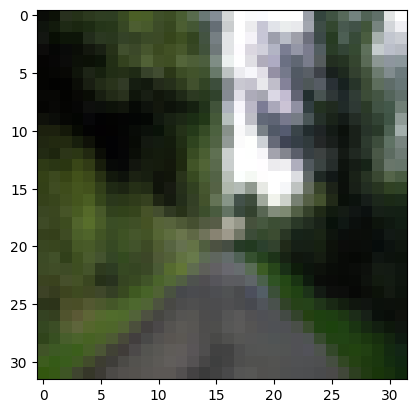

road


In [4]:
origin_img = Image.fromarray(dataset.data[img_idx[0]])
# display(origin_img.resize((224, 224)))
plt.imshow(origin_img)
plt.show()
print(idx_to_name[dataset.targets[img_idx[0]]])

In [5]:
if not hasattr(config, 'expert_kernel_num'):
    config.expert_kernel_num = 1
network = CNN_MoE_Net_V1(logger, config.backbone, config.pretrained,
                    pretrain_path=config.pretrain_path, layer_names=config.layer_names, mode=config.mode,
                    expert_kernel_num=config.expert_kernel_num, expert_per_task=config.expert_per_task, topk=config.topk)
network.update_fc(data_manager.get_task_size(0))
network = network.cuda()

logger.info('Initializing task-{} MoEs in network...'.format(0))
with torch.no_grad():
    network.eval()
    network(torch.rand(1, 3, config.img_size, config.img_size).cuda())
network.load_state_dict(checkpoint['state_dict'])

2023-10-07 11:39:05,132 => getting model from torch...
2023-10-07 11:39:05,352 => Created resnet18 !
2023-10-07 11:39:05,353 => loaded pretrained weights from default
2023-10-07 11:39:05,354 => Removed original backbone--resnet18's fc classifier !
2023-10-07 11:39:05,355 => Created classifier head with output dim 10
2023-10-07 11:39:05,729 => Initializing task-0 MoEs in network...
2023-10-07 11:39:14,388 => Created MoE v1 before layer-layer1_MoEs, feature_map_shape = (64, 56, 56)
2023-10-07 11:39:14,412 => Created MoE v1 before layer-layer2_MoEs, feature_map_shape = (64, 56, 56)
2023-10-07 11:39:14,434 => Created MoE v1 before layer-layer3_MoEs, feature_map_shape = (128, 28, 28)
2023-10-07 11:39:14,466 => Created MoE v1 before layer-layer4_MoEs, feature_map_shape = (256, 14, 14)


<All keys matched successfully>

In [6]:
logits, feature_outputs = network(inputs.cuda())
layer_id = 'layer1_MoEs'
print('gate scores: {}'.format(feature_outputs[layer_id]['gate_scores'][0].data))
print('topk gate indexs: {}'.format(feature_outputs[layer_id]['expert_idxs'][0].data))

gate scores: tensor([0.1933, 0.1963, 0.1965, 0.1960, 0.2179], device='cuda:0')
topk gate indexs: tensor([4, 2], device='cuda:0')


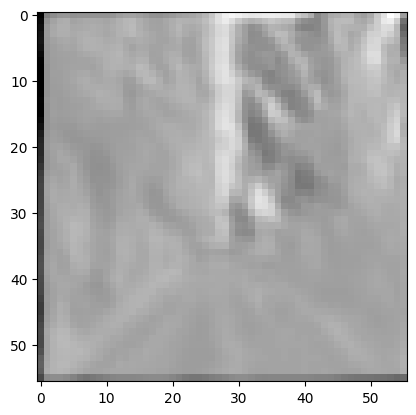

In [7]:
normed_query_fm = feature_outputs[layer_id]['query_fm'][0] - min(feature_outputs[layer_id]['query_fm'][0])
normed_query_fm /= 1e-7 + max(normed_query_fm)
normed_query_fm = normed_query_fm.detach().reshape(fm_size_dict[layer_id], fm_size_dict[layer_id]).cpu().numpy()
plt.imshow(255 * normed_query_fm, cmap='gray')
plt.show()

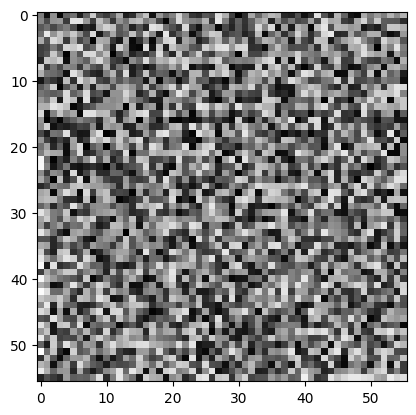

In [8]:
gate_prototype = network.__getattr__(layer_id)[0].gate.prototype[feature_outputs[layer_id]['expert_idxs'][0][0]]
normed_gate_prototype = gate_prototype - min(gate_prototype)
normed_gate_prototype /= 1e-7 + max(normed_gate_prototype)
normed_gate_prototype = normed_gate_prototype.detach().reshape(fm_size_dict[layer_id], fm_size_dict[layer_id]).cpu().numpy()
plt.imshow(255 * normed_gate_prototype, cmap='gray')
plt.show()

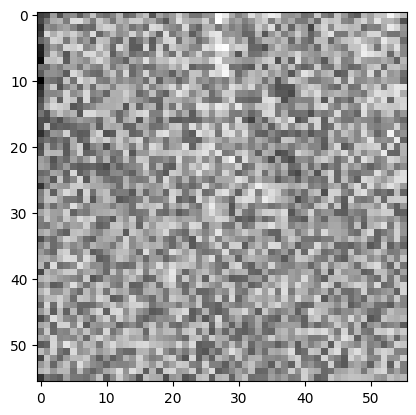

In [9]:
merged_fm = normed_query_fm + normed_gate_prototype
normed_merged_fm = merged_fm - merged_fm.min()
normed_merged_fm /= 1e-7 + normed_merged_fm.max()
plt.imshow(255 * normed_merged_fm, cmap='gray')
plt.show()

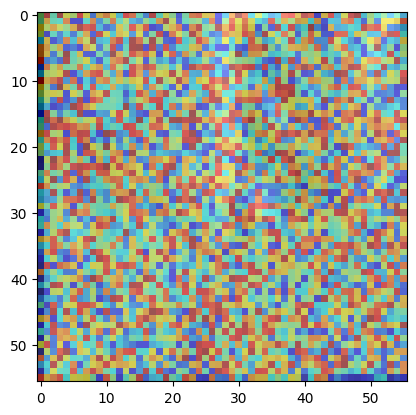

In [10]:
def show_cam_on_image(img: np.ndarray,
                      mask: np.ndarray,
                      use_rgb: bool = False,
                      colormap: int = cv2.COLORMAP_JET) -> np.ndarray:
    """ This function overlays the cam mask on the image as an heatmap.
    By default thees heatmap is in BGR format.

    :param img: The base image in RGB or BGR format.
    :param mask: The cam mask.
    :param use_rgb: Whether to use an RGB or BGR heatmap, this should be set to True if 'img' is in RGB format.
    :param colormap: The OpenCV colormap to be used.
    :returns: The default image with the cam overlay.
    """

    heatmap = cv2.applyColorMap((255 * mask).astype(np.uint8), colormap)
    if use_rgb:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255

    if np.max(img) > 1:
        raise Exception(
            "The input image should np.float32 in the range [0, 1]")

    cam = heatmap + img
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

# print(normed_query_fm.shape)
# print(normed_gate_prototype.shape)
plt.imshow(show_cam_on_image(normed_query_fm[:,:, None], normed_gate_prototype))

In [11]:
56*56

3136

In [1]:
import os
class_name = ['None'] * (100)
txt_path = os.path.join("/data16/Public/Datasets", 'miniImageNet', 'val.txt')
with open(txt_path, 'r') as f:
    lines = f.readlines()

for line in lines:
    name, target = line.split(' ')
    cls_name = name.split('/')[2]
    if class_name[int(target)] == 'None':
        class_name[int(target)] = cls_name

print(class_name)

['Americanegret', 'artichoke', 'badger', 'beerbottle', 'birdhouse', 'bottlecap', 'Bread', 'butterfly', 'butternutsquash', 'carrier', 'carton', 'carwheel', 'cassetteplayer', 'catamaran', 'chickadee', 'chiffonier', 'chimpanzee', 'coffeepot', 'convertible', 'crocodile', 'cucumber', 'daybed', 'desktopcomputer', 'digitalclock', 'dishrag', 'dustcart', 'firetruck', 'fly', 'freightcar', 'gartersnake', 'gibbon', 'goldfish', 'golfball', 'gorilla', 'Grasshopper', 'greatgreyowl', 'horn', 'hourglass', 'husky', 'hyaena', 'jeep', 'keypad', 'leatherbackturtle', 'leopard', 'limpkin', 'lizard', 'malamute', 'mask', 'matchstick', 'measuringcup', 'minibus', 'missile', 'mobilehome', 'ModelT', 'monitor', 'moped', 'numbfish', 'Oriole', 'ostrich', 'Persiancat', 'person', 'piano', 'pooltable', 'projector', 'radiotelescope', 'Recordsheet', 'recreationalvehicle', 'reflexcamera', 'revolver', 'rocker', 'Rottweiler', 'rule', 'runningshoe', 'SaintBernard', 'schoolbus', 'Siamese', 'soapdispenser', 'stonewall', 'stopli

In [4]:
len(class_name)

100

In [7]:
import json
json_path = os.path.join("datasets","all_prompts","imagenet_prompts_base.json")

with open(json_path, "r") as f:
    templates = json.load(f)

err = []
for cls in class_name:
    if cls not in templates:
        err.append(cls)

print(len(err), err)

65 ['Americanegret', 'beerbottle', 'bottlecap', 'Bread', 'butterfly', 'butternutsquash', 'carrier', 'carton', 'carwheel', 'cassetteplayer', 'coffeepot', 'crocodile', 'daybed', 'desktopcomputer', 'digitalclock', 'dishrag', 'dustcart', 'firetruck', 'freightcar', 'gartersnake', 'golfball', 'Grasshopper', 'greatgreyowl', 'horn', 'hyaena', 'keypad', 'leatherbackturtle', 'lizard', 'malamute', 'measuringcup', 'mobilehome', 'ModelT', 'numbfish', 'Oriole', 'Persiancat', 'person', 'piano', 'pooltable', 'radiotelescope', 'Recordsheet', 'recreationalvehicle', 'reflexcamera', 'rocker', 'rule', 'runningshoe', 'SaintBernard', 'schoolbus', 'Siamese', 'soapdispenser', 'stonewall', 'stoplight', 'streetsign', 'suspensionbridge', 'tabby', 'tablelamp', 'taxi', 'thatch', 'tileroof', 'Tram', 'warplane', 'washer', 'watertower', 'web', 'whitefox', 'wolfspider']


In [9]:
key_list = templates.keys()

In [11]:
a_list = [item for item in key_list if item.startswith("American")]

In [12]:
a_list

['American robin',
 'American dipper',
 'American bullfrog',
 'American alligator',
 'American lobster',
 'American coot',
 'American Staffordshire Terrier',
 'American black bear']

In [2]:
import os
txt_path = os.path.join("/data16/Public/Datasets", 'CUB_200_2011', "classes.txt")
class_name = ['None'] * (200)
with open(txt_path, 'r') as f:
    lines = f.readlines()

for line in lines:
    target, name = line.split(' ')
    cls_name = name.split('.')[1].replace('_', ' ')
    if class_name[int(target)-1] == 'None':
        class_name[int(target)-1] = cls_name.split('\n')[0]
classes_name = class_name

In [3]:
classes_name

['Black footed Albatross',
 'Laysan Albatross',
 'Sooty Albatross',
 'Groove billed Ani',
 'Crested Auklet',
 'Least Auklet',
 'Parakeet Auklet',
 'Rhinoceros Auklet',
 'Brewer Blackbird',
 'Red winged Blackbird',
 'Rusty Blackbird',
 'Yellow headed Blackbird',
 'Bobolink',
 'Indigo Bunting',
 'Lazuli Bunting',
 'Painted Bunting',
 'Cardinal',
 'Spotted Catbird',
 'Gray Catbird',
 'Yellow breasted Chat',
 'Eastern Towhee',
 'Chuck will Widow',
 'Brandt Cormorant',
 'Red faced Cormorant',
 'Pelagic Cormorant',
 'Bronzed Cowbird',
 'Shiny Cowbird',
 'Brown Creeper',
 'American Crow',
 'Fish Crow',
 'Black billed Cuckoo',
 'Mangrove Cuckoo',
 'Yellow billed Cuckoo',
 'Gray crowned Rosy Finch',
 'Purple Finch',
 'Northern Flicker',
 'Acadian Flycatcher',
 'Great Crested Flycatcher',
 'Least Flycatcher',
 'Olive sided Flycatcher',
 'Scissor tailed Flycatcher',
 'Vermilion Flycatcher',
 'Yellow bellied Flycatcher',
 'Frigatebird',
 'Northern Fulmar',
 'Gadwall',
 'American Goldfinch',
 'Euro

In [25]:
len(classes_name)
with open("./cub200_classes.txt", 'a+') as f:
    for item in classes_name:
        f.write(item+'\n')

In [20]:
classes_name

['Black footed Albatross',
 'Laysan Albatross',
 'Sooty Albatross',
 'Groove billed Ani',
 'Crested Auklet',
 'Least Auklet',
 'Parakeet Auklet',
 'Rhinoceros Auklet',
 'Brewer Blackbird',
 'Red winged Blackbird',
 'Rusty Blackbird',
 'Yellow headed Blackbird',
 'Bobolink',
 'Indigo Bunting',
 'Lazuli Bunting',
 'Painted Bunting',
 'Cardinal',
 'Spotted Catbird',
 'Gray Catbird',
 'Yellow breasted Chat',
 'Eastern Towhee',
 'Chuck will Widow',
 'Brandt Cormorant',
 'Red faced Cormorant',
 'Pelagic Cormorant',
 'Bronzed Cowbird',
 'Shiny Cowbird',
 'Brown Creeper',
 'American Crow',
 'Fish Crow',
 'Black billed Cuckoo',
 'Mangrove Cuckoo',
 'Yellow billed Cuckoo',
 'Gray crowned Rosy Finch',
 'Purple Finch',
 'Northern Flicker',
 'Acadian Flycatcher',
 'Great Crested Flycatcher',
 'Least Flycatcher',
 'Olive sided Flycatcher',
 'Scissor tailed Flycatcher',
 'Vermilion Flycatcher',
 'Yellow bellied Flycatcher',
 'Frigatebird',
 'Northern Fulmar',
 'Gadwall',
 'American Goldfinch',
 'Euro

In [5]:
import json
json_path = os.path.join("datasets","all_prompts","bird_prompts_base.json")

with open(json_path, "r") as f:
    templates = json.load(f)
err = []
for cls in class_name:
    if cls not in templates:
        err.append(cls)

print(len(err), err)

500
62 ['Black footed Albatross', 'Laysan Albatross', 'Sooty Albatross', 'Crested Auklet', 'Least Auklet', 'Parakeet Auklet', 'Rhinoceros Auklet', 'Brewer Blackbird', 'Cardinal', 'Spotted Catbird', 'Chuck will Widow', 'Brandt Cormorant', 'Red faced Cormorant', 'Pelagic Cormorant', 'Shiny Cowbird', 'Mangrove Cuckoo', 'Frigatebird', 'Northern Fulmar', 'European Goldfinch', 'Heermann Gull', 'Ivory Gull', 'Slaty backed Gull', 'Anna Hummingbird', 'Green Violetear', 'Long tailed Jaeger', 'Pomarine Jaeger', 'Florida Jay', 'Green Kingfisher', 'Pied Kingfisher', 'Ringed Kingfisher', 'White breasted Kingfisher', 'Red legged Kittiwake', 'Mockingbird', 'Nighthawk', 'Clark Nutcracker', 'Scott Oriole', 'White Pelican', 'Sayornis', 'Whip poor Will', 'Horned Puffin', 'White necked Raven', 'Geococcyx', 'Great Grey Shrike', 'Baird Sparrow', 'Brewer Sparrow', 'Harris Sparrow', 'Henslow Sparrow', 'Le Conte Sparrow', 'Lincoln Sparrow', 'Nelson Sharp tailed Sparrow', 'Savannah Sparrow', 'Tree Sparrow', 'Cap

### cifar100_class_name

In [1]:
import pickle
import os
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

root = "/data16/Public/Datasets"
meta_Name = os.path.join(root, "cifar-100-python", "meta")
meta_test_Name = os.path.join(root, "cifar-100-python", "test")
Meta_dic= unpickle(meta_Name)
test_dic= unpickle(meta_test_Name)
fine_label_names=Meta_dic['fine_label_names']
seed1993_order_cifar = [68, 56, 78, 8, 23, 84, 90, 65, 74, 76, 40, 89, 3, 92, 55, 9, 26, 80, 43, 38, 58, 70, 77, 1, 85, 19, 17, 50, 28, 53, 13, 81, 45, 82, 6, 59, 83, 16, 15, 44, 91, 41, 72, 60, 79, 52, 20, 10, 31, 54, 37, 95, 14, 71, 96, 98, 97, 2, 64, 66, 42, 22, 35, 86, 24, 34, 87, 21, 99, 0, 88, 27, 18, 94, 11, 12, 47, 25, 30, 46, 62, 69, 36, 61, 7, 63, 75, 5, 32, 4, 51, 48, 73, 93, 39, 67, 29, 49, 57, 33]

In [2]:
fine_label_names

['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle',
 'bowl',
 'boy',
 'bridge',
 'bus',
 'butterfly',
 'camel',
 'can',
 'castle',
 'caterpillar',
 'cattle',
 'chair',
 'chimpanzee',
 'clock',
 'cloud',
 'cockroach',
 'couch',
 'crab',
 'crocodile',
 'cup',
 'dinosaur',
 'dolphin',
 'elephant',
 'flatfish',
 'forest',
 'fox',
 'girl',
 'hamster',
 'house',
 'kangaroo',
 'keyboard',
 'lamp',
 'lawn_mower',
 'leopard',
 'lion',
 'lizard',
 'lobster',
 'man',
 'maple_tree',
 'motorcycle',
 'mountain',
 'mouse',
 'mushroom',
 'oak_tree',
 'orange',
 'orchid',
 'otter',
 'palm_tree',
 'pear',
 'pickup_truck',
 'pine_tree',
 'plain',
 'plate',
 'poppy',
 'porcupine',
 'possum',
 'rabbit',
 'raccoon',
 'ray',
 'road',
 'rocket',
 'rose',
 'sea',
 'seal',
 'shark',
 'shrew',
 'skunk',
 'skyscraper',
 'snail',
 'snake',
 'spider',
 'squirrel',
 'streetcar',
 'sunflower',
 'sweet_pepper',
 'table',
 'tank',
 'telephone',
 'television',
 'tig

In [40]:
fine_grain = [42,89,14,51,12]
for item in fine_grain:
    print(fine_label_names[seed1993_order_cifar[item]])

seal
beaver
otter
whale
bear


### ImageNet100 classes

In [4]:
from datasets.imagenet100 import ImageNet100
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


idata = ImageNet100()
idata.get_class_name(os.path.join('/data16/Public/Datasets/', 'imagenet_100', 'imagenet100_classes.txt'))
i100 = idata.classes_name

seed1993_order = [68, 56, 78, 8, 23, 84, 90, 65, 74, 76, 40, 89, 3, 92, 55, 9, 26, 80, 43, 38, 58, 70, 77, 1, 85, 19, 17, 50, 28, 53, 13, 81, 45, 82, 6, 59, 83, 16, 15, 44, 91, 41, 72, 60, 79, 52, 20, 10, 31, 54, 37, 95, 14, 71, 96, 98, 97, 2, 64, 66, 42, 22, 35, 86, 24, 34, 87, 21, 99, 0, 88, 27, 18, 94, 11, 12, 47, 25, 30, 46, 62, 69, 36, 61, 7, 63, 75, 5, 32, 4, 51, 48, 73, 93, 39, 67, 29, 49, 57, 33]
seed30_order = [20, 91, 34, 52, 8, 74, 21, 88, 80, 89, 82, 38, 0, 77, 42, 67, 68, 92, 48, 10, 93, 4, 51, 72, 1, 87, 78, 24, 71, 54, 95, 32, 63, 69, 29, 30, 19, 60, 59, 43, 26, 5, 25, 83, 22, 36, 66, 47, 86, 9, 39, 56, 98, 44, 73, 31, 70, 40, 57, 14, 75, 58, 85, 28, 55, 33, 50, 13, 94, 15, 11, 79, 64, 84, 90, 27, 62, 6, 16, 76, 81, 18, 35, 61, 96, 49, 65, 7, 41, 3, 46, 17, 53, 2, 23, 12, 97, 45, 99, 37]
print(i100[seed1993_order[97]])
print(i100[seed1993_order[98]])
print(i100[seed1993_order[99]])
print(i100[seed1993_order[39]])
print(i100[seed1993_order[48]])
# print(i100[seed30_order[37]])
# print(i100[seed30_order[92]])
# print(i100[seed30_order[83]])
# print(i100[seed30_order[76]])
# print(i100[seed30_order[61]])

Nile crocodile
garter snake
loggerhead sea turtle
alligator lizard
tree frog


In [29]:
from PIL import Image

def pil_loader(path):
    '''
    Ref:
    https://pytorch.org/docs/stable/_modules/torchvision/datasets/folder.html#ImageFolder
    '''
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')



class DummyDataset(Dataset):
    def __init__(self, data, targets, transform, use_path=False, two_view=False, ret_origin=False):
        assert len(data) == len(targets), 'Data size error!'
        self.data = data
        self.targets = targets
        self.ret_origin = ret_origin

        self.transform = transform
        self.use_path = use_path
        self.two_view = two_view

        self.no_transform = transforms.PILToTensor()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.use_path:
            origin_img = pil_loader(self.data[idx])
        else:
            origin_img = Image.fromarray(self.data[idx])
        image = self.transform(origin_img)
        label = self.targets[idx]
        addition_info = self.no_transform(origin_img) if self.ret_origin else idx
        if self.two_view:
            if self.use_path:
                image2 = self.transform(pil_loader(self.data[idx]))
            else:
                image2 = self.transform(Image.fromarray(self.data[idx]))
            image = [image, image2]

        return addition_info, image, label
    
    def set_ret_origin(self, mode:bool):
        self.ret_origin = mode


def get_data(root_dir, fn):
    source_path = os.path.join(root_dir, 'ilsvrc2012')
    file = open(os.path.join(root_dir, 'imagenet_100', fn))
    file_name_list = file.read().split('\n')
    file.close()
    data = []
    targets = []
    for file_name in file_name_list:
        temp = file_name.split(' ')
        if len(temp) == 2:
            data.append(os.path.join(source_path, temp[0]))
            targets.append(int(temp[1]))
    return np.array(data), np.array(targets)

test_data, test_targets = get_data(root_dir ='/data16/Public/Datasets/', fn= 'val_100.txt')

classes_0_data, classes_0_targets = test_data[:50], test_targets[:50]
test_trsf =   transforms.Compose([
            transforms.Resize((256,256)), # 256
            transforms.CenterCrop(224), # 224
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
classes_0_dataset = DummyDataset(data=classes_0_data, targets=classes_0_targets, transform=test_trsf, use_path=True)
classes_0_dataloader = DataLoader(classes_0_dataset, batch_size=50, shuffle=False)
_, cls_0_imgs, cls_0_targets = next(iter(classes_0_dataloader))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


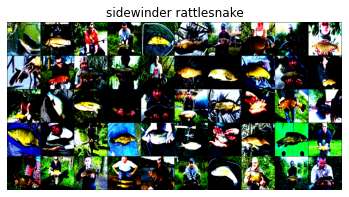

In [30]:
cls_0_imgs.shape
plt.imshow(torchvision.utils.make_grid(cls_0_imgs,nrow=10, padding=2).numpy().transpose((1, 2, 0)))
plt.title(i100[seed1993_order[0]])
plt.axis('off')
plt.show()
